# NAB Dataset - Time-Series Anomaly Detection

## Load and explore a dataset

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import STL
import json
from glob import glob


In [2]:
file_path = 'data/realKnownCause/ambient_temperature_system_failure.csv'
df = pd.read_csv(file_path)

print(df.head())

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551


In [3]:
# convert the timestamp values to datatime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace = True)

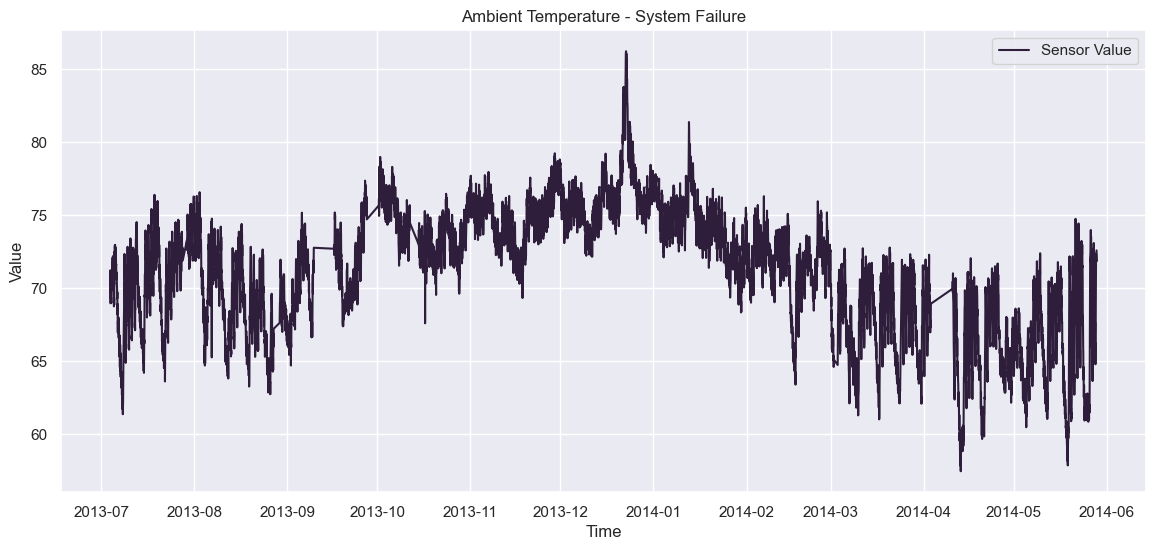

In [4]:
# plot the data
# set style and color palette
sns.set_theme(style = 'darkgrid', palette = 'mako')

plt.figure(figsize = (14,6))
plt.plot(df.index, df['value'], label = 'Sensor Value')
plt.title('Ambient Temperature - System Failure')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Preprocess the data

For this time-series data, the proprocessing steps are as follows:
- Sort by timestamp (often unnecessary, as a lot of data is already sorted)
- Handle missing values (here we'll use linear interpolation)
- Normalize values (optional, but useful for some models)


In [5]:
df = df.sort_index()
df = df.interpolate(method = 'time')
df['value_norm'] = (df['value'] - df['value'].mean()) / df['value'].std()

## Base Models - Rolling Z-Score and STL Decomposition + Residual Anomaly Detection

### Rolling Z-Score

In [6]:
# with median absolute deviation (MAD) instead of std for robustness
window_size = 50

rolling_median = df['value_norm'].rolling(window = window_size).median()
rolling_mad = df['value_norm'].rolling(window = window_size).apply(lambda x: np.median(np.abs(x - np.median(x))), raw = True)
df['mad_score'] = (df['value_norm'] - rolling_median) / (rolling_mad + 1e-9) # to avoid dividing by zero

### STL Decomposition + Residual Anomaly Detection

In [7]:
# also with MAD
period = 1440 # Adjust for dataset frequency
stl = STL(df['value_norm'], period = period)
result = stl.fit()
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

residual_median = df['residual'].median()
residual_mad = np.median(np.abs(df['residual'] - residual_median))
df['stl_mad_score'] = (df['residual'] - residual_median) / (residual_mad + 1e-9)

### Evaluate Models

In [8]:
# Load ground truth labels
label_file = 'labels/combined_windows.json'
with open(label_file, 'r') as f:
    anomaly_windows = json.load(f)

dataset_key = 'realKnownCause/ambient_temperature_system_failure.csv'
windows = anomaly_windows.get(dataset_key, [])
anomaly_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in windows]


In [9]:
# Evaluation utilities
def is_in_anomaly_window(timestamp, windows):
    return any(start <= timestamp <= end for start, end in windows)

def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0  else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0  else 0
    return precision, recall, f1

df['true_anomaly'] = df.index.to_series().apply(lambda x: is_in_anomaly_window(x, anomaly_periods))

In [10]:
# Threshold tuning loop
z_thresholds = np.linspace(1.0, 10, 30)
stl_thresholds = np.linspace(1.0, 10, 30)
z_results, stl_results = [], []

In [11]:
# look best scores across thresholds

for z_thresh in z_thresholds:
    df['z_anomaly'] = df['mad_score'].abs() > z_thresh
    df['tp'] = df['z_anomaly'] & df['true_anomaly']
    df['fp'] = df['z_anomaly'] & ~df['true_anomaly']
    df['fn'] = ~df['z_anomaly'] & df['true_anomaly']
    tp, fp, fn = df['tp'].sum(), df['fp'].sum(), df['fn'].sum()
    precision, recall, f1 = compute_metrics(tp, fp, fn)
    z_results.append({'threshold': z_thresh, 'precision': precision, 'recall': recall, 'f1': f1})

for stl_thresh in stl_thresholds:
    df['stl_anomaly'] = df['stl_mad_score'].abs() > stl_thresh
    df['tp'] = df['stl_anomaly'] & df['true_anomaly']
    df['fp'] = df['stl_anomaly'] & ~df['true_anomaly']
    df['fn'] = ~df['stl_anomaly'] & df['true_anomaly']
    tp, fp, fn = df['tp'].sum(), df['fp'].sum(), df['fn'].sum()
    precision, recall, f1 = compute_metrics(tp, fp, fn)
    stl_results.append({'threshold': stl_thresh, 'precision': precision, 'recall': recall, 'f1': f1})

z_results_df = pd.DataFrame(z_results)
stl_results_df = pd.DataFrame(stl_results)

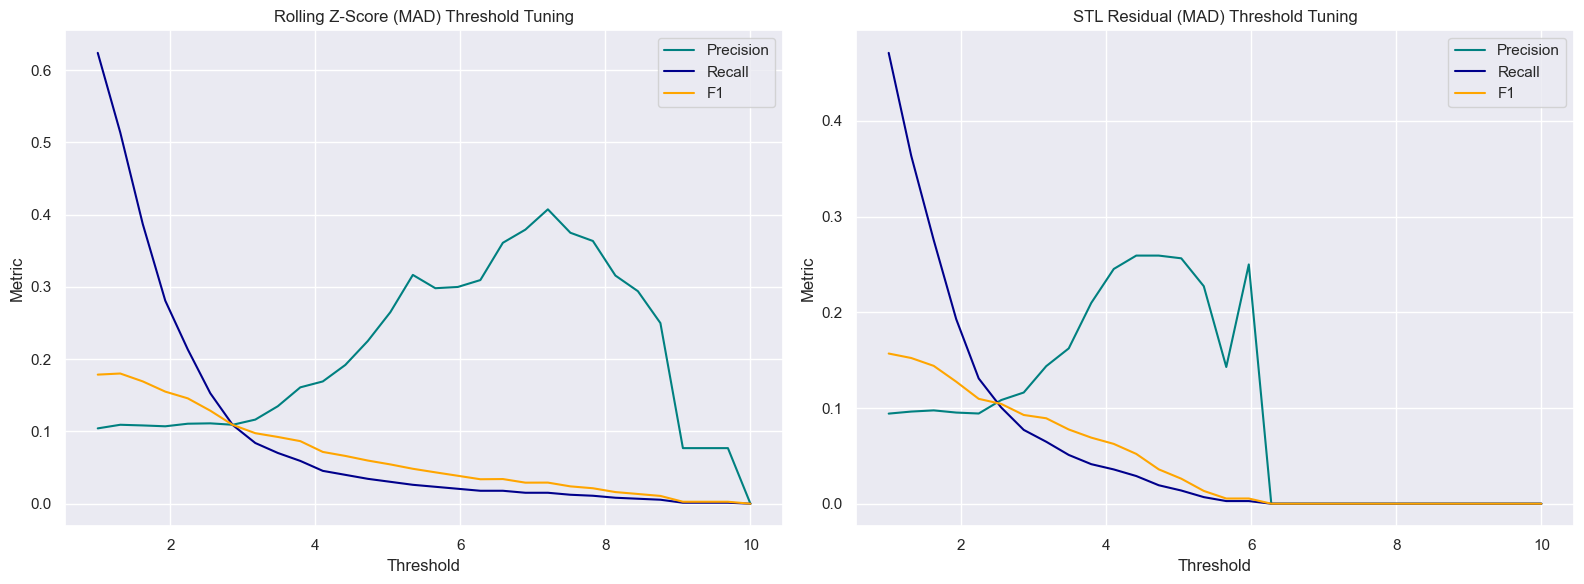

In [12]:
# plot the threshold tuning results
fig, axs = plt.subplots(1, 2, figsize = (16,6))
axs[0].plot(z_results_df['threshold'], z_results_df['precision'], label = 'Precision', color = 'teal')
axs[0].plot(z_results_df['threshold'], z_results_df['recall'], label = 'Recall', color = 'darkblue')
axs[0].plot(z_results_df['threshold'], z_results_df['f1'], label = 'F1', color = 'orange')
axs[0].set_title('Rolling Z-Score (MAD) Threshold Tuning')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Metric')
axs[0].legend()
axs[0].grid(True)


axs[1].plot(stl_results_df['threshold'], stl_results_df['precision'], label = 'Precision', color = 'teal')
axs[1].plot(stl_results_df['threshold'], stl_results_df['recall'], label = 'Recall', color = 'darkblue')
axs[1].plot(stl_results_df['threshold'], stl_results_df['f1'], label = 'F1', color = 'orange')
axs[1].set_title('STL Residual (MAD) Threshold Tuning')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Metric')
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()

The above results indicate that the models above are not very well-suited to the selected dataset, but before I move on to any deep-learning models, I want to cycle through more of the datasets in the NAB collection. 

# Modularized code for application to multiple datasets

Before moving on to deep learning models, I want to modularlize the above code, and apply it to multiple datasets in the NAB collection. With this implementation, I can see which datasets are well-suited to the methods I've already devised here. 

## Import libraries and set dependencies

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
import json
import os
from glob import glob

# set seaborn style and color palette
sns.set_theme(style = 'darkgrid', palette = 'mako')

## Load ground-truth labels 

In [14]:
label_file = 'labels/combined_windows.json'
with open(os.path.expanduser(label_file), 'r') as f:
    anomaly_windows = json.load(f)

## Model fit and evaluation functions

In [15]:
def is_in_anomaly_window(timestamp, windows):
    return any(start <= timestamp <= end for start, end in windows)

def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def evaluate_file(file_path, period=1440, window_size=50):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # Normalize
    df['value_norm'] = (df['value'] - df['value'].mean()) / df['value'].std()

    # STL Decomposition
    stl = STL(df['value_norm'], period=period)
    result = stl.fit()
    df['residual'] = result.resid

    # Ground truth
    #dataset_key = os.path.join(*file_path.split(os.sep)[-2:])
    dataset_key = os.path.relpath(file_path, start=os.path.expanduser('data'))
    dataset_key = dataset_key.replace('\\', '/')  # For Windows compatibility
    print(f"looking for: {dataset_key}")
    windows = anomaly_windows.get(dataset_key, [])
    if dataset_key not in anomaly_windows:
        print(f"[Warning] No anomaly window found for {dataset_key}")
    anomaly_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in windows]
    df['true_anomaly'] = df.index.to_series().apply(lambda x: is_in_anomaly_window(x, anomaly_periods))

    # Rolling Z-Score with MAD
    rolling_median = df['value_norm'].rolling(window=window_size).median()
    rolling_mad = df['value_norm'].rolling(window=window_size).apply(
        lambda x: np.median(np.abs(x - np.median(x))), raw=True)
    df['mad_score'] = (df['value_norm'] - rolling_median) / (rolling_mad + 1e-9)

    # STL MAD Score
    residual_median = df['residual'].median()
    residual_mad = np.median(np.abs(df['residual'] - residual_median))
    df['stl_mad_score'] = (df['residual'] - residual_median) / (residual_mad + 1e-9)

    # Best score across a sweep of thresholds
    best_f1_z, best_f1_stl = 0, 0
    best_z_thresh, best_stl_thresh = 0, 0

    for thresh in np.linspace(1.0, 5.0, 20):
        df['z_anomaly'] = df['mad_score'].abs() > thresh
        df['tp'] = df['z_anomaly'] & df['true_anomaly']
        df['fp'] = df['z_anomaly'] & ~df['true_anomaly']
        df['fn'] = ~df['z_anomaly'] & df['true_anomaly']
        tp, fp, fn = df['tp'].sum(), df['fp'].sum(), df['fn'].sum()
        _, _, f1 = compute_metrics(tp, fp, fn)
        if f1 > best_f1_z:
            best_f1_z = f1
            best_z_thresh = thresh

    for thresh in np.linspace(1.0, 5.0, 20):
        df['stl_anomaly'] = df['stl_mad_score'].abs() > thresh
        df['tp'] = df['stl_anomaly'] & df['true_anomaly']
        df['fp'] = df['stl_anomaly'] & ~df['true_anomaly']
        df['fn'] = ~df['stl_anomaly'] & df['true_anomaly']
        tp, fp, fn = df['tp'].sum(), df['fp'].sum(), df['fn'].sum()
        _, _, f1 = compute_metrics(tp, fp, fn)
        if f1 > best_f1_stl:
            best_f1_stl = f1
            best_stl_thresh = thresh

    return {
        'file': dataset_key,
        'best_z_f1': best_f1_z,
        'z_thresh': best_z_thresh,
        'best_stl_f1': best_f1_stl,
        'stl_thresh': best_stl_thresh
    }

## Loop through all realKnownCause datasets

In [16]:
data_dir = os.path.expanduser('data/realKnownCause/')
csv_files = sorted(glob(os.path.join(data_dir, '*.csv')))

results = []
for file_path in csv_files:
    try:
        #for key in anomaly_windows.keys():
           # print(repr(key))
        result = evaluate_file(file_path)
        results.append(result)
    except Exception as e:
        print(f"Failed on {file_path}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_stl_f1', ascending=False)

looking for: realKnownCause/ambient_temperature_system_failure.csv
looking for: realKnownCause/cpu_utilization_asg_misconfiguration.csv
looking for: realKnownCause/ec2_request_latency_system_failure.csv
looking for: realKnownCause/machine_temperature_system_failure.csv
looking for: realKnownCause/nyc_taxi.csv
looking for: realKnownCause/rogue_agent_key_hold.csv
looking for: realKnownCause/rogue_agent_key_updown.csv


## Show summary

                                                file  best_z_f1  best_stl_f1
3  realKnownCause/machine_temperature_system_fail...   0.195252     0.494338
1  realKnownCause/cpu_utilization_asg_misconfigur...   0.147734     0.347929
6          realKnownCause/rogue_agent_key_updown.csv   0.068303     0.336151
2  realKnownCause/ec2_request_latency_system_fail...   0.151695     0.195077
4                        realKnownCause/nyc_taxi.csv   0.185784     0.175626
0  realKnownCause/ambient_temperature_system_fail...   0.180254     0.156917
5            realKnownCause/rogue_agent_key_hold.csv   0.178054     0.000000


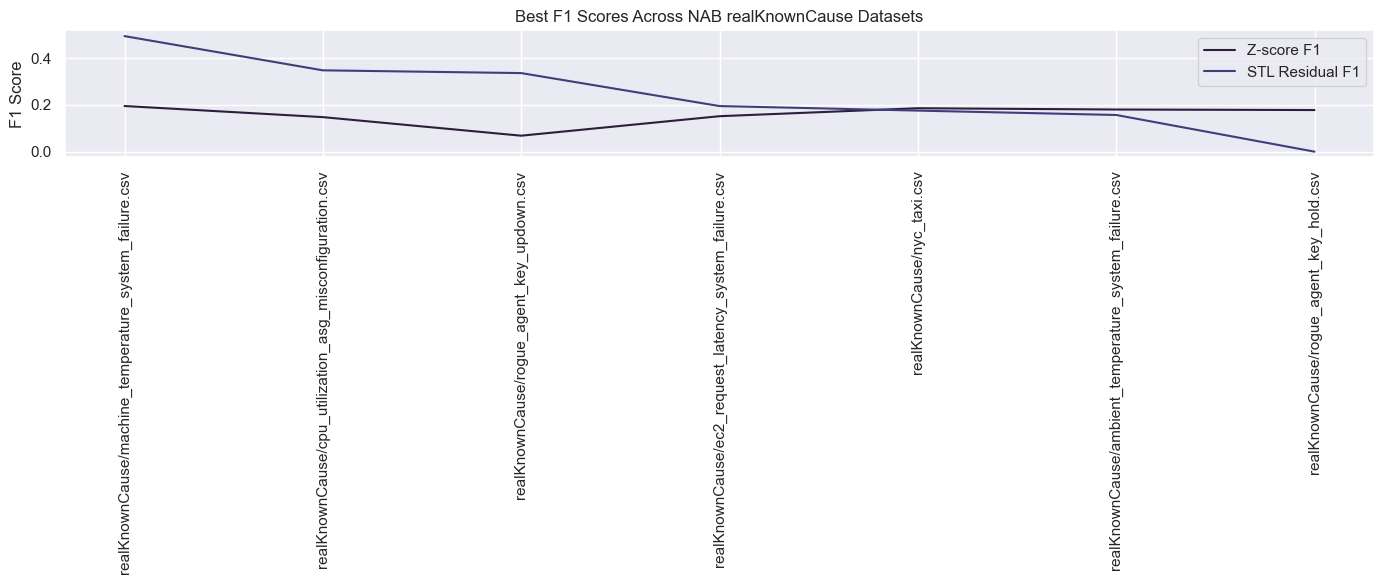

In [17]:
print(results_df[['file', 'best_z_f1', 'best_stl_f1']])

# Plot results
plt.figure(figsize = (14,6))
plt.plot(results_df['file'], results_df['best_z_f1'], label = 'Z-score F1')
plt.plot(results_df['file'], results_df['best_stl_f1'], label = 'STL Residual F1')
plt.xticks(rotation = 90)
plt.title('Best F1 Scores Across NAB realKnownCause Datasets')
plt.ylabel('F1 Score')
plt.legend()
plt.tight_layout()
plt.show()

While the F1 scores for some of the datasets indicate that although we're squeezing as much performance as we can from these models, they simply cannot account for the contextual anomalies in the data, and for that we'll need deep learing techniques. I will switch to a different notebook for LSTM-based forecasting. 